#대회
[월간 데이콘 TV 손동작 제어 인식 AI 경진대회](https://dacon.io/competitions/official/236050/codeshare/7371?page=1&dtype=recent)

[주제] TV를 제어하는 사용자의 손동작을 분류하는 AI 모델 개발

[설명] TV를 제어하는 사용자의 손동작을 분류하기 위해서 30프레임의 1초 분량의 동영상(mp4)들이 입력 데이터로 주어지며,

동영상을 입력으로 받아 사용자의 손동작을 5가지의 Class로 분류하는 AI 모델을 개발해야합니다.

Class 0 : 스마트 TV 볼륨을 높입니다.

Class 1 : 스마트 TV 볼륨을 낮춥니다.

Class 2 : 스마트 TV의 재생 영상을 10초 전으로 점프합니다.

Class 3 : 스마트 TV의 재생 영상을 10초 앞으로 점프합니다.

Class 4 : 스마트 TV의 재생 영상을 중지합니다.

In [41]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [42]:
!unzip -qq "/content/gdrive/MyDrive/open (4).zip"

replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [43]:
import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# albumentations = 이미지 증강
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore') 
     

In [44]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [45]:

CFG = {
    'FPS':30,
    'IMG_SIZE':128,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':4,
    'SEED':41
}

In [46]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [47]:
df = pd.read_csv('./train.csv')

In [48]:
df

,id,path,label
0,TRAIN_000,./train/TRAIN_000.mp4,3
1,TRAIN_001,./train/TRAIN_001.mp4,0
2,TRAIN_002,./train/TRAIN_002.mp4,1
3,TRAIN_003,./train/TRAIN_003.mp4,4
4,TRAIN_004,./train/TRAIN_004.mp4,4
...,...,...,...
605,TRAIN_605,./train/TRAIN_605.mp4,0
606,TRAIN_606,./train/TRAIN_606.mp4,2
607,TRAIN_607,./train/TRAIN_607.mp4,1
608,TRAIN_608,./train/TRAIN_608.mp4,4


In [49]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=CFG['SEED'])
     

#customdataset

In [50]:

class CustomDataset(Dataset):
  def __init__(self,video_path_list,label_list):
    self.video_path_list = video_path_list
    self.label_list = label_list
  def __getitem__(self,index):
    frames = self.get_video(self.video_path_list[index])

    if self.label_list is not None:
      label = self.label_list[index]
      return frames, label
    else:
      return frames
    
  def __len__(self):
    return len(self.video_path_list)
  #우선 __init__, __getitem__, __len__을 먼저 정의하고 , get_video를 함수로 정의했다.
  def get_video(self,path):
    frames = []
    cap = cv2.VideoCapture(path)
    for _ in range(CFG['FPS']):
        _,img = cap.read()
        img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
        img = img / 255
        frames.append(img)
    return torch.FloatTensor((np.array(frames))).permute(3,0,1,2)
    

    



```
cap = cv2.VideoCapture(path)
```
opencv 함수 중 영상 객체(파일)을 가지고 오는 함수



```
cv2.VideoCapture.read(image=None) -> retval, image
```
재생되는 비디오를 한 프레임씩 읽어들이는 함수로 비디오 프레임을 제대로 읽었다면, retval값은 TRUE, 실패하면 False가 저장된다.

read()명렁어를 통해 카메라, 동영상에서 프레임을 받아올 수 있습니다.

 retval : 성공하면 True, 실패하면 False.


```
cv2.resize(src, dsize, dst=None, fx=None, fy=None, interpolation=None) -> dst
```
• src: 입력 영상

• dsize: 결과 영상 크기. (w, h) 튜플. (0, 0)이면 fx와 fy 값을 이용하여 결정. ---> 여기서는 (CFG['IMG_SIZE'], CFG['IMG_SIZE'])

• dst: 출력 영상

• fx, fy: x와 y방향 스케일 비율(scale factor). (dsize 값이 0일 때 유효)

• interpolation: 보간법 지정. 기본값은 cv2.INTER_LINEAR


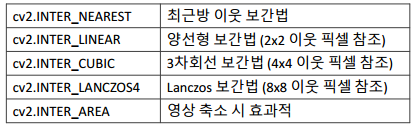

1. cv2.INTER_NEAREST - 최근방 이웃 보간법

 가장 빠르지만 퀄리티가 많이 떨어집니다. 따라서 잘 쓰이지 않습니다.

 

2. cv2.INTER_LINEAR - 양선형 보간법(2x2 이웃 픽셀 참조)

 4개의 픽셀을 이용합니다.

 효율성이 가장 좋습니다. 속도도 빠르고 퀄리티도 적당합니다.

 

3. cv2.INTER_CUBIC - 3차회선 보간법(4x4 이웃 픽셀 참조)

 16개의 픽셀을 이용합니다.

 cv2.INTER_LINEAR 보다 느리지만 퀄리티는 더 좋습니다.

 

4. cv2.INTER_LANCZOS4 - Lanczos 보간법 (8x8 이웃 픽셀 참조)

 64개의 픽셀을 이용합니다.

 좀더 복잡해서 오래 걸리지만 퀄리티는 좋습니다.

 

5. cv2.INTER_AREA - 영상 축소시 효과적

 영역적인 정보를 추출해서 결과 영상을 셋팅합니다.

 영상을 축소할 때 이용합니다.



```
FloatTensor
```
실수형 텐서를 만듬.



```
torch.FloatTensor((np.array(frames))).permute(3,0,1,2)
```
permute()는 모든 차원들을 맞교환할 수 있다. 비슷한 걸로 tranpose가 있는데, transpose는 차원 2개만 교환할 수 있다.

예를 들면

```
x = torch.rand(16, 32, 3)
y = x.tranpose(0, 2)  # [3, 32, 16]
z = x.permute(2, 1, 0)  # [3, 32, 16]
```
즉 이걸 해석해보면 frame 리스트 형식에서 넘파이로 변환하고, 실수형 텐서로 다시 바꾼다. 그리고 permute로 차원을 바꾼다. 


In [51]:
train

,id,path,label
45,TRAIN_045,./train/TRAIN_045.mp4,2
479,TRAIN_479,./train/TRAIN_479.mp4,1
487,TRAIN_487,./train/TRAIN_487.mp4,3
219,TRAIN_219,./train/TRAIN_219.mp4,3
319,TRAIN_319,./train/TRAIN_319.mp4,2
...,...,...,...
407,TRAIN_407,./train/TRAIN_407.mp4,3
601,TRAIN_601,./train/TRAIN_601.mp4,1
243,TRAIN_243,./train/TRAIN_243.mp4,4
321,TRAIN_321,./train/TRAIN_321.mp4,3


In [52]:
train_dataset = CustomDataset(train['path'].values, train['label'].values)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

In [53]:
train['label'].values

array([2, 1, 3, 3, 2, 1, 1, 0, 4, 2, 4, 4, 0, 1, 4, 0, 3, 4, 3, 0, 2, 4,
       3, 3, 0, 1, 0, 2, 3, 4, 0, 1, 3, 1, 3, 2, 1, 0, 4, 1, 3, 3, 0, 1,
       3, 4, 3, 0, 0, 2, 3, 0, 1, 2, 3, 3, 1, 2, 3, 3, 2, 2, 2, 3, 4, 3,
       4, 3, 2, 3, 3, 4, 3, 2, 4, 2, 0, 4, 3, 1, 3, 0, 1, 3, 3, 4, 2, 3,
       3, 3, 1, 3, 4, 4, 2, 4, 4, 4, 4, 3, 3, 0, 2, 3, 1, 0, 1, 4, 2, 4,
       4, 3, 1, 1, 1, 3, 3, 2, 3, 1, 1, 1, 4, 3, 1, 0, 0, 0, 2, 4, 2, 3,
       0, 0, 2, 3, 1, 3, 2, 4, 1, 3, 0, 1, 3, 4, 4, 1, 4, 1, 2, 4, 2, 0,
       3, 2, 1, 2, 2, 0, 4, 3, 1, 1, 4, 3, 3, 1, 2, 0, 2, 2, 0, 1, 2, 0,
       3, 3, 3, 2, 4, 1, 2, 3, 2, 1, 3, 3, 0, 1, 1, 2, 2, 1, 0, 4, 0, 0,
       3, 2, 1, 0, 4, 3, 0, 4, 0, 0, 4, 3, 3, 0, 2, 0, 3, 3, 1, 0, 2, 2,
       3, 2, 2, 2, 0, 1, 1, 0, 0, 2, 3, 4, 3, 0, 2, 3, 2, 0, 0, 3, 2, 1,
       4, 3, 1, 1, 0, 1, 4, 2, 3, 3, 2, 4, 4, 4, 1, 1, 4, 1, 3, 3, 2, 1,
       3, 1, 0, 1, 3, 1, 2, 3, 0, 4, 3, 1, 3, 0, 0, 1, 3, 0, 3, 3, 4, 1,
       0, 1, 0, 0, 4, 1, 3, 0, 3, 2, 0, 4, 1, 1, 1,

In [54]:
train['path'].values

array(['./train/TRAIN_045.mp4', './train/TRAIN_479.mp4',
       './train/TRAIN_487.mp4', './train/TRAIN_219.mp4',
       './train/TRAIN_319.mp4', './train/TRAIN_042.mp4',
       './train/TRAIN_227.mp4', './train/TRAIN_249.mp4',
       './train/TRAIN_029.mp4', './train/TRAIN_150.mp4',
       './train/TRAIN_505.mp4', './train/TRAIN_380.mp4',
       './train/TRAIN_054.mp4', './train/TRAIN_133.mp4',
       './train/TRAIN_300.mp4', './train/TRAIN_495.mp4',
       './train/TRAIN_083.mp4', './train/TRAIN_210.mp4',
       './train/TRAIN_266.mp4', './train/TRAIN_220.mp4',
       './train/TRAIN_020.mp4', './train/TRAIN_233.mp4',
       './train/TRAIN_167.mp4', './train/TRAIN_218.mp4',
       './train/TRAIN_018.mp4', './train/TRAIN_082.mp4',
       './train/TRAIN_288.mp4', './train/TRAIN_146.mp4',
       './train/TRAIN_095.mp4', './train/TRAIN_343.mp4',
       './train/TRAIN_215.mp4', './train/TRAIN_357.mp4',
       './train/TRAIN_056.mp4', './train/TRAIN_332.mp4',
       './train/TRAIN_400.mp4',

In [55]:
val

,id,path,label
515,TRAIN_515,./train/TRAIN_515.mp4,3
190,TRAIN_190,./train/TRAIN_190.mp4,0
327,TRAIN_327,./train/TRAIN_327.mp4,1
325,TRAIN_325,./train/TRAIN_325.mp4,0
459,TRAIN_459,./train/TRAIN_459.mp4,4
...,...,...,...
226,TRAIN_226,./train/TRAIN_226.mp4,2
377,TRAIN_377,./train/TRAIN_377.mp4,0
498,TRAIN_498,./train/TRAIN_498.mp4,0
553,TRAIN_553,./train/TRAIN_553.mp4,4


In [56]:
val_dataset = CustomDataset(val['path'].values, val['label'].values)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [57]:
class BaseModel(nn.Module):
  def __init__(self,num_classes=5):
    super(BaseModel, self).__init__()
    self.feature_extract = nn.Sequential(
        nn.Conv3d(3,8,(3,3,3)),
        nn.ReLU(),
        nn.BatchNorm3d(8),
        nn.MaxPool3d(2),
        nn.Conv3d(8,32,(2,2,2)),
        nn.ReLU(),
        nn.BatchNorm3d(32),
        nn.MaxPool3d(2),
        nn.Conv3d(32,64,(2,2,2)),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2),
        nn.Conv3d(64,128,(2,2,2)),
        nn.ReLU(),
        nn.BatchNorm3d(128),
        nn.MaxPool3d((1,7,7))
    )
    self.classifier = nn.Linear(512,num_classes)

  def forward(self,x):
    batch_size=x.size(0)
    x = self.feature_extract(x)
    x = x.view(batch_size,-1)
    x = self.classifier(x)
    return x


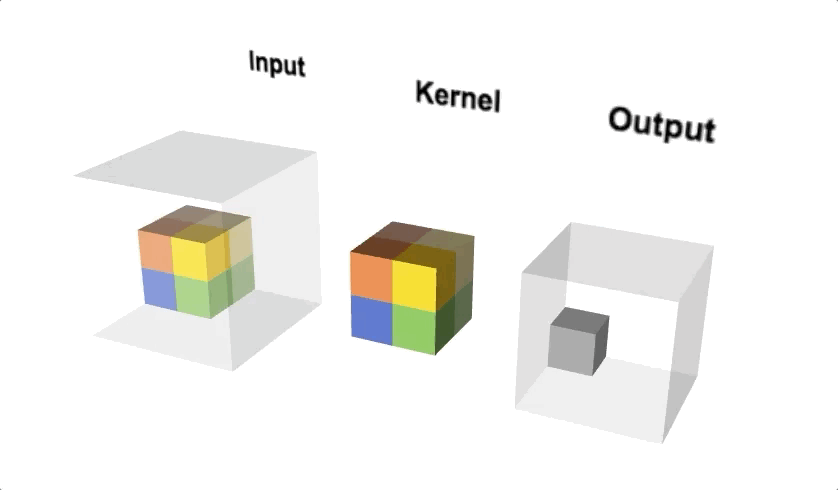

pytorch_3d(input, output, kernel, stride, padding, dilation, activation function, pooling)

Conv3d(3,8,(3,3,3)) 여기보면 keral이 3d라서 (3,3,3)으로 포현했다.

처음부터 끝까지 같은 learning rate를 사용할 수도 있지만, 학습과정에서 learning rate를 조정하는 learning rate scheduler를 사용할 수도 있다. 처음엔 큰 learning rate(보폭)으로 빠르게 optimize를 하고 최적값에 가까워질수록 learning rate(보폭)를 줄여 미세조정을 하는 것이 학습이 잘된다고 알려져있다. learning rate를 decay하는 방법이외에도 learning rate를 줄였다 늘렸다 하는 것이 더 성능향상에 도움이 된다는 연구결과도 있다.

optimizer와 scheduler를 먼저 정의한 후, 학습할 때 batch마다 optimizer.step() 하고 epoch마다 scheduler.step()을 해주면 된다. 대략적인 코드를 작성하면 아래와 같은 흐름이다.

In [58]:
from sklearn.utils import validation
def train(model,optimizer, train_loader, val_loader, scheduler, device):
  model.to(device)
  criterion = nn.CrossEntropyLoss().to(device)

  best_val_score = 0
  best_model = None

  for epoch in range(1,CFG['EPOCHS']+1):
    model.train()
    train_loss = []
    for videos, labels in tqdm(iter(train_loader)):
        videos = videos.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = model(videos)
        #걍 파이토치는 loss를 이렇게 두는 듯. 일단 외워라. 이전에 분류기도 이렇게 코드를 짬.
        loss = criterion(output, labels)

        loss.backward()
        #optimizer.step() 을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정
        optimizer.step()
        #loss.item() 으로 손실이 갖고 있는 스칼라 값을 가져올 수 있습니다
        train_loss.append(loss.item())

    _val_loss,_val_score = validation(model,criterion,val_loader,device)
    _train_loss = np.mean(train_loss)
    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')

    if scheduler is not None:
      scheduler.step(_val_score)

    if best_val_score < _val_score:
      best_val_score = _val_score
      best_model = model

  return best_model


ter(호출가능한객체, 반복을끝낼값)

to(device) = gpu 할당을 선언

In [59]:
def validation(model,criterion,val_loader,device):
  model.eval()
  val_loss = []
  preds, trues = [], []

  with torch.no_grad():
    for videos, labels in tqdm(iter(val_loader)):
      videos = videos.to(device)
      labels = labels.to(device)

      logit = model(videos)

      loss = criterion(logit, labels)

      val_loss.append(loss.item())

      preds += logit.argmax(1).detach().cpu().numpy().tolist()
      trues += labels.detach().cpu().numpy().tolist()

    _val_loss = np.mean(val_loss)

  _val_score = f1_score(trues, preds, average='macro')

  return _val_loss, _val_score



.eval() 함수는 evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수인 셈이다.


```
 torch.no_grad() 
```
 torch.no_grad() 의 주된 목적은 autograd를 끔으로써 메모리 사용량을 줄이고 연산 속도를 높히기 위함이다


In [60]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.53331] Val Loss : [1.33194] Val F1 : [0.45483]


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.85913] Val Loss : [1.08051] Val F1 : [0.58057]


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.52317] Val Loss : [1.03573] Val F1 : [0.63214]


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.33235] Val Loss : [0.89439] Val F1 : [0.65353]


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.19379] Val Loss : [0.88136] Val F1 : [0.69390]


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.10450] Val Loss : [0.85054] Val F1 : [0.70342]


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.07536] Val Loss : [0.90810] Val F1 : [0.68849]


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.05653] Val Loss : [0.76058] Val F1 : [0.73943]


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.05146] Val Loss : [0.83341] Val F1 : [0.71910]


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.04453] Val Loss : [0.90657] Val F1 : [0.71732]
